# `Занятие 6: Автокодировщики. Часть 1`

## Немного об апроксимации
Из-за бутылочного горлышка в автокодировщиках, мы теряем часть информации. 
У нас всегда есть трейд-офф - какую часть информации мы готовы потерять при снижении размерности. Что нам важнее - мало факторов или снижение информации. Чем меньше будет факторов в латентном пространстве - тем более средние величины мы будем восстанавливать.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему mnist цифры все более размытые при снижении размерности кода в автоэнкодерах).



## Manifold hypothesis

Гипотеза о многообразие гласит, что многомерны данные из пеального мира (например, изображения) лежат на многообразиях низкой размерности, вложенных в пространство большой размерности.

Более подробно на эту тему написано в [статье](https://bjlkeng.github.io/posts/manifolds/).

Здесь я приведу небольшую цитату из нее:\
*The main idea here is that even though our real-world data is high-dimensional, there is actually some lower-dimensional representation. For example, all "cat images" might lie on a lower-dimensional manifold compared to say their original 256x256x3 image dimensions. This makes sense because we are empirically able to the learn these things in a capacity limited neural network. Otherwise learning an arbitrary 256x256x3 function would be intractable*

Семинарский ноутбук составлен на основе другой [статьи](https://habr.com/ru/post/331500/)

In [1]:
 # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.cos(x1)+np.sin(x1-3)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
from itertools import cycle
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

In [2]:
len(x1), len(fx), np.vstack([x1, fx]).T.shape, noise.shape, len(idxs)

(1000, 1000, (1000, 2), (1000, 2), 25)

In [3]:
vdots

array([[-2.12286569,  0.31712127],
       [-2.04414623,  0.51360059],
       [-1.76943552,  0.78844975],
       [-1.64612319,  0.86974686],
       [-1.47597776,  1.18221073],
       [-1.29520373,  1.19596148],
       [-1.1371475 ,  1.24106322],
       [-0.99527919,  1.32532605],
       [-0.89769825,  1.23152787],
       [-0.6763624 ,  1.23231165],
       [-0.43594178,  1.1892528 ],
       [-0.31640593,  1.09941524],
       [-0.18264076,  0.82657238],
       [ 0.08673612,  0.75560286],
       [ 0.26134693,  0.55498726],
       [ 0.35945735,  0.37604858],
       [ 0.58886906,  0.11624161],
       [ 0.78076154, -0.16584223],
       [ 0.79597483, -0.34443284],
       [ 1.1138633 , -0.5056057 ],
       [ 1.26537637, -0.70285066],
       [ 1.51513038, -0.88808509],
       [ 1.62626572, -1.10348669],
       [ 1.83547957, -1.21605274],
       [ 2.10654488, -1.3750125 ]])

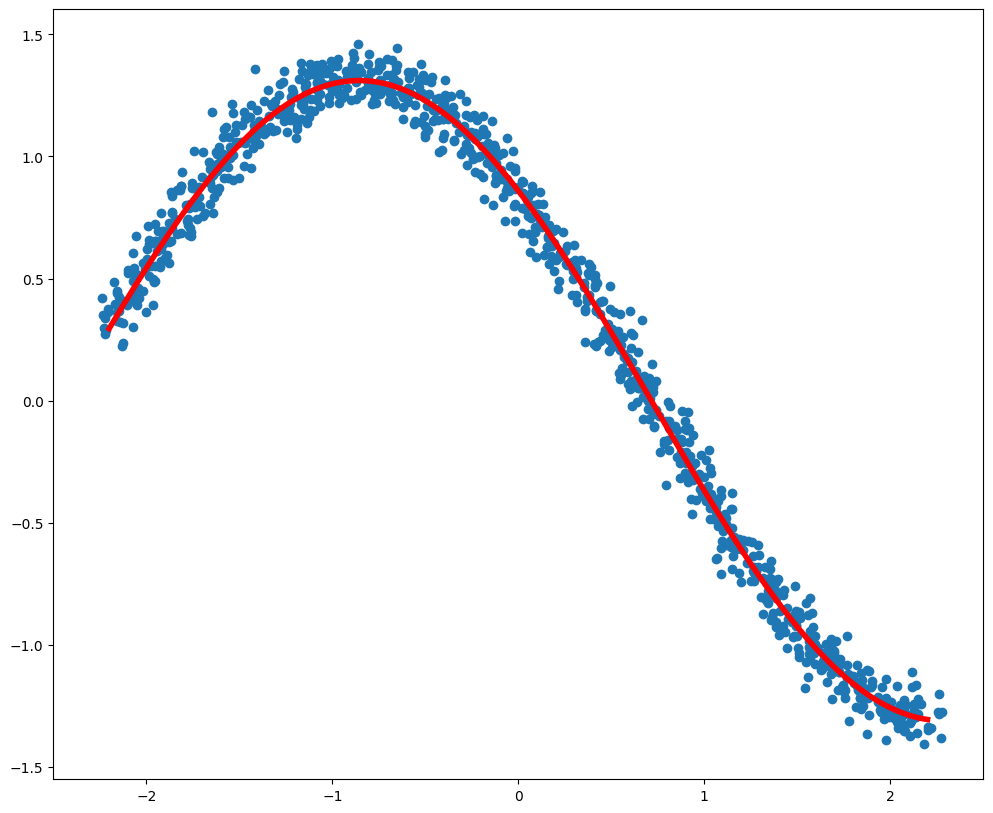

In [4]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)

Перепишем наш автоэнкодер под новые данные

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

In [6]:
class PcaAutoencoder(nn.Module):

    def __init__(self, inp_shape, code_size=1):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        
        # смотрим, что нам надо сделать
        self.encoder = torch.nn.Linear(inp_shape, code_size)
        self.decoder = torch.nn.Linear(code_size, inp_shape)

    def forward(self, x):
        # и тут
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EPOCHS = 40

cuda


In [8]:
# Train your autoencoder
def train(model, train_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss = []
    train_loss_epoch = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            optimizer.zero_grad()
            
            batch = X[0].to(device)  # [0] is needed due to X being a list
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()

            train_loss.append(loss.detach().cpu().numpy())
        
        train_loss_epoch.append(np.mean(train_loss))

        if epoch % 5 == 0:
            print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}")

    return model, train_loss_epoch

In [9]:
input_shape = dots.shape[1]
input_shape

2

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = PcaAutoencoder(input_shape, code_size=1)
autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [11]:
autoencoder

PcaAutoencoder(
  (encoder): Linear(in_features=2, out_features=1, bias=True)
  (decoder): Linear(in_features=1, out_features=2, bias=True)
)

In [12]:
X_train = torch.tensor(dots, dtype=torch.float32)
dataset_train = TensorDataset(X_train)

BATCH_SIZE = 32

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [13]:
next(iter(train_loader))

[tensor([[ 1.4045, -0.8598],
         [ 2.0203, -1.3007],
         [ 1.8655, -1.1885],
         [ 2.1383, -1.2947],
         [ 1.8549, -1.2502],
         [-0.2195,  0.9964],
         [ 0.4770,  0.2899],
         [ 0.4100,  0.4746],
         [-0.6602,  1.3684],
         [ 0.6005,  0.0469],
         [-0.0816,  0.8347],
         [ 0.0779,  0.6542],
         [ 2.0680, -1.3249],
         [-2.0064,  0.5403],
         [ 0.9889, -0.3770],
         [-2.0732,  0.6054],
         [-1.7154,  0.8745],
         [-0.6197,  1.2033],
         [ 0.4290,  0.2403],
         [ 1.2897, -0.5928],
         [-2.1348,  0.4128],
         [-2.0620,  0.4026],
         [ 0.5592,  0.1322],
         [ 1.6432, -1.0336],
         [ 1.4271, -0.7754],
         [-0.1389,  0.9964],
         [-0.5871,  1.3192],
         [-0.9357,  1.2474],
         [ 0.5881,  0.1727],
         [ 1.4961, -0.8955],
         [-0.7857,  1.2726],
         [-1.0851,  1.3034]])]

**Важно:** `test_loader` нужен для того, чтобы при инференсе не перемешивать данные

In [14]:
model, train_loss = train(autoencoder, train_loader, device=DEVICE, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 1.567498
After 5 epochs, training loss: 1.315700
After 10 epochs, training loss: 1.135988
After 15 epochs, training loss: 0.982979
After 20 epochs, training loss: 0.855382
After 25 epochs, training loss: 0.749381
After 30 epochs, training loss: 0.661860
After 35 epochs, training loss: 0.589804
After 40 epochs, training loss: 0.531092
After 45 epochs, training loss: 0.483461


**Важно:** на [StackOverflow](https://stackoverflow.com/questions/55533116/pca-inverse-transform-in-sklearn) приведено хорошее пояснение того, как из двухмерного облака точек получается одномерная линия вследтвие выполнения `pca.inverse_transform(pca.fit_transform(dots))`, т.е. что из себя орнажевая и черная линии ниже

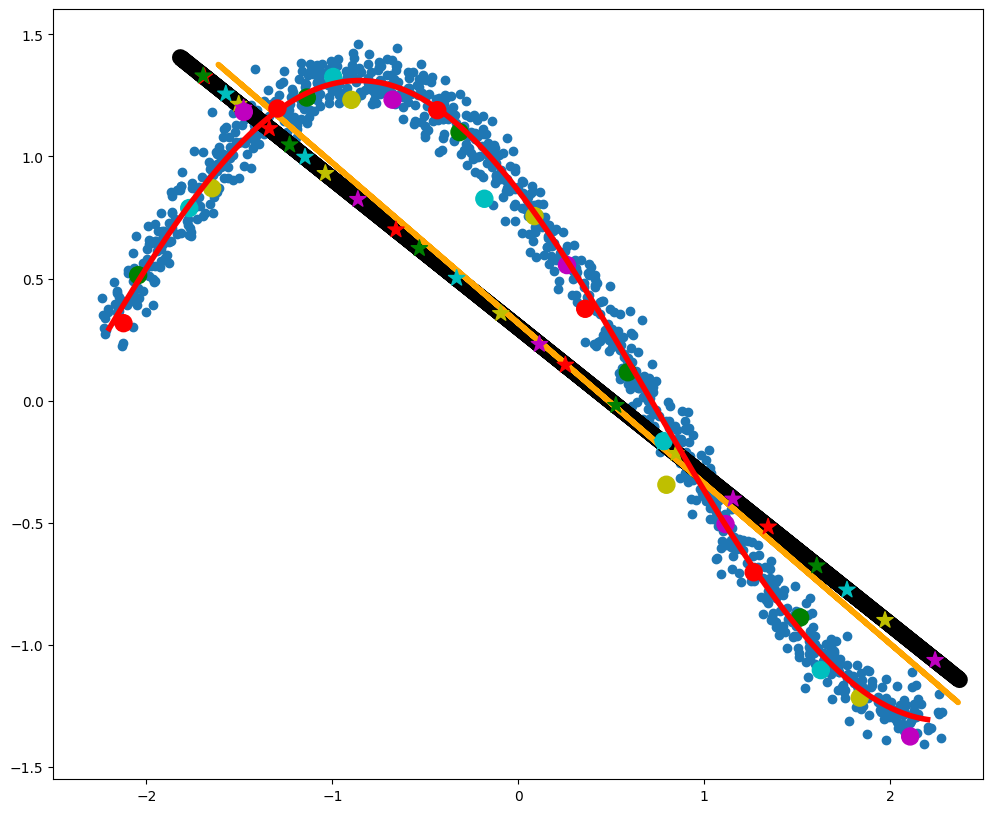

In [15]:
# Применение линейного автоэнкодера
res = []
with torch.no_grad():
    for X in test_loader:
        batch = X[0].to(DEVICE)  # [0] is needed due to X being a list
        reconstruction, _ = model(batch)
        reconstruction = reconstruction.cpu()
        res.append(reconstruction)
pdots = torch.cat(res)
vpdots = pdots[idxs]

# Применение PCA
from sklearn.decomposition import PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='black', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots[:,0], vpdots[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

Мы видим, что достаточно простое многообразие мы нашли. Добавим слоев.

In [16]:
class DeepAutoencoder(nn.Module):

    def __init__(self, inp_shape, code_size=1):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        #  давайтес сделаем больше слоев
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(inp_shape, 2 * inp_shape),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * inp_shape, 2 * inp_shape),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * inp_shape, code_size)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(code_size, 2 * inp_shape),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * inp_shape, 2 * inp_shape),
            torch.nn.ReLU(),
            torch.nn.Linear(2 * inp_shape, inp_shape)
        )
        
    def forward(self, x):
        # а должно что-то поменяться с прошлого шага?
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [17]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

deep_autoencoder = DeepAutoencoder(input_shape, code_size=1)
deep_autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(deep_autoencoder.parameters(), lr=1e-2)

deep_model, train_loss = train(deep_autoencoder, 
                                train_loader, 
                                device=DEVICE, epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

After 0 epochs, training loss: 1.173203
After 5 epochs, training loss: 0.342577
After 10 epochs, training loss: 0.204695
After 15 epochs, training loss: 0.144637
After 20 epochs, training loss: 0.111903
After 25 epochs, training loss: 0.091535


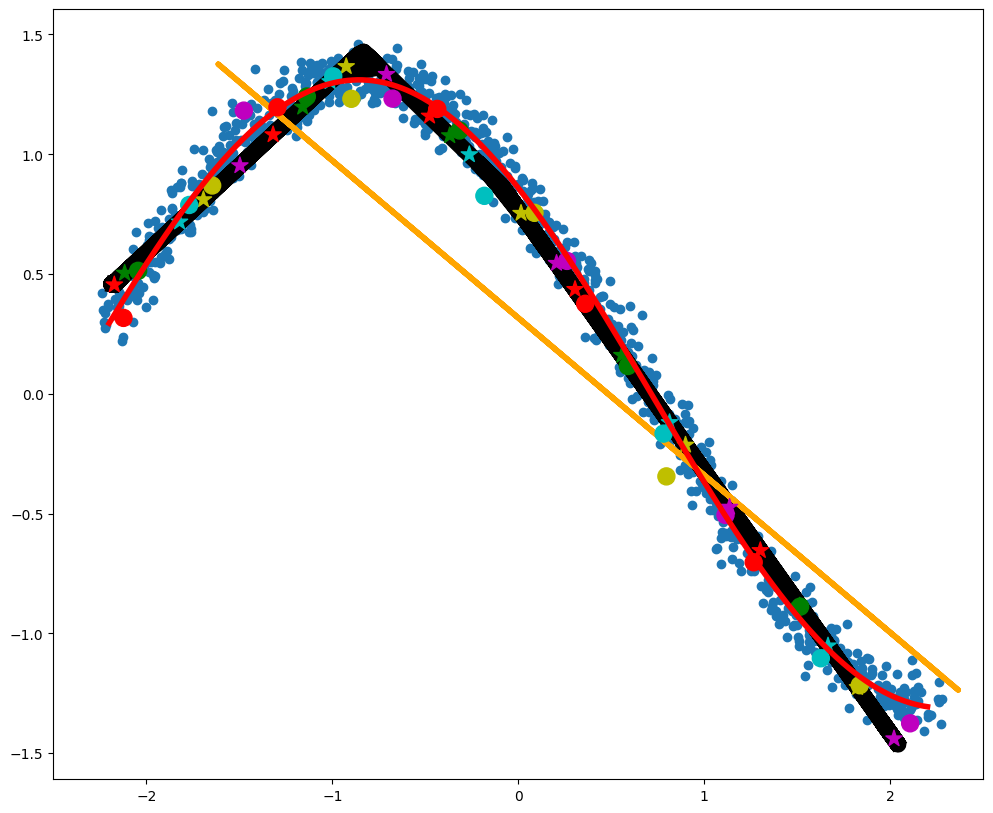

In [18]:
res = []
with torch.no_grad():
    for X in test_loader:
        batch = X[0].to(DEVICE)  # [0] is needed due to X being a list
        reconstruction, _ = deep_model(batch)
        reconstruction = reconstruction.cpu()
        res.append(reconstruction)
pdots_deep = torch.cat(res)
vpdots_deep = pdots_deep[idxs]

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_deep[:,0], pdots_deep[:,1], color='black', linewidth=12, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vpdots_deep[:,0], vpdots_deep[:,1], color=colors*5, marker='*', s=150, zorder=5)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

У такого автоэнкодера практически идеально получилось построить определяющее многообразие: черная кривая почти совпадает с красной.

Глубокий автоэнкодер теоретически сможет найти многообразие произвольной сложности, например, такое, около которого лежат цифры в 784-мерном пространстве.


Все же у достаточно сложного автоэнкодера есть возможность переобучиться. Продемонстрируем это!
Мы берем и показываем одни и теже точки автоэнкодеру множество раз.

In [19]:
dots_oft = np.vstack([dots[idxs]]*4000)

X_train_oft = torch.tensor(dots_oft, dtype=torch.float32)
X_test_oft = torch.tensor(dots[idxs], dtype=torch.float32)  # важно: в тесте только выбранные точки без повторений
dataset_train_oft = TensorDataset(X_train_oft)
dataset_test_oft = TensorDataset(X_test_oft)

BATCH_SIZE = 32

train_loader_oft = DataLoader(dataset_train_oft, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader_oft = DataLoader(dataset_test_oft, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [20]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

deep_autoencoder = DeepAutoencoder(input_shape, code_size=1)
deep_autoencoder.to('cuda')

# Use Adam optimizer
optimizer = optim.Adam(deep_autoencoder.parameters(), lr=3e-4)

overfit_model, train_loss = train(deep_autoencoder, 
                                  train_loader_oft, 
                                  device='cuda', epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.721071
After 5 epochs, training loss: 0.135034
After 10 epochs, training loss: 0.074743
After 15 epochs, training loss: 0.052001
After 20 epochs, training loss: 0.040084
After 25 epochs, training loss: 0.032750
After 30 epochs, training loss: 0.027781
After 35 epochs, training loss: 0.024192
After 40 epochs, training loss: 0.021478
After 45 epochs, training loss: 0.019354


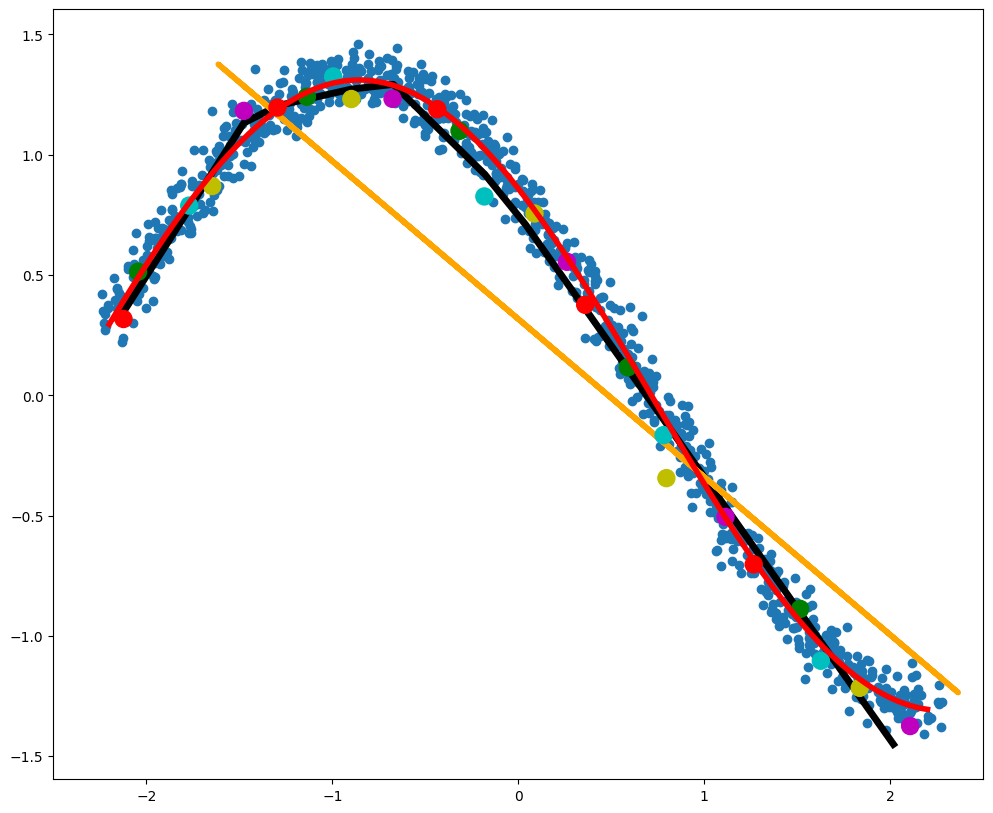

In [23]:
res = []
with torch.no_grad():
    for X in test_loader_oft:
        batch = X[0].to('cuda')  # [0] is needed due to X being a list
        reconstruction, _ = overfit_model(batch)
        res.append(reconstruction)
pdots_deep_oft = torch.cat(res).cpu()

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_deep_oft[:, 0], pdots_deep_oft[:, 1], color='black', linewidth=5, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

Мы видим, что наша линия проходит через конкретные точки, и очень плохо описывает правильное многообразие.

В теории мы можем апроксимизировать какое угодно распределение.
Мы стремимся найти такое латентное пространство, 
где мы небольшие сдвиги в латентных переменных все равно остаются в том же классе.  

**Важная мысль:** если взять два объекта и посмотреть на объекты, лежащие на произвольной кривой между ними, то скорее всего промежуточные объекты не будут принадлежать генеральной совокупности, т. к. многообразие на котором лежит генеральная совокупность может быть сильно искривленным и малоразмерным.

In [24]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [25]:
train_data = train_data.data[:, None, :, :]
test_data = test_data.data[:, None, :, :]

X_train = torch.tensor(train_data, dtype=torch.float32)
X_test = torch.tensor(test_data, dtype=torch.float32)

dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=256, 
                                          shuffle=False, 
                                          num_workers=1),
}

/tmp/ipykernel_207317/2959893525.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(train_data, dtype=torch.float32)
/tmp/ipykernel_207317/2959893525.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(test_data, dtype=torch.float32)


In [26]:
# Сверточный автоэнкодер
class ConvAutoencoder(nn.Module):

    def __init__(self):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        # input is (1 x 28 x 28)
        self.encoder = nn.Sequential(nn.Conv2d(1, 128, kernel_size=(7, 7), padding=3),  # 128x28x28
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=(2, 2), padding=1),       # 128x14x14
                                     nn.Conv2d(128, 32, kernel_size=(3, 3), padding=1), # 32x14x14
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=(2, 2)),                  # 32x7x7
                                     nn.Conv2d(32, 1, kernel_size=(7, 7), padding=3)    # 1x7x7
                                     )
        # На этом моменте представление  (1, 7, 7) т.е. 49-размерное

        self.decoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3),   # 32x7x7
                                     nn.Upsample(scale_factor=2, mode='nearest'),   # 32x14x14
                                     nn.Conv2d(32, 128, kernel_size=(3, 3), padding=1), # 128x14x14
                                     nn.Upsample(scale_factor=2, mode='nearest'),   # 128x28x28
                                     nn.Conv2d(128, 1, kernel_size=(7, 7), padding=3)   # 1x28x28
                                     )
        # Вернулись к исходной размерности  (1, 28, 28) т.е. 784-размерное

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [27]:
next(iter(loaders['train']))[0].shape

torch.Size([256, 1, 28, 28])

In [28]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

conv_autoencoder = ConvAutoencoder()
conv_autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=3e-4)

conv_model, train_loss = train(conv_autoencoder, 
                                loaders['train'], 
                                device=DEVICE, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 2523.058594
After 5 epochs, training loss: 1639.428345
After 10 epochs, training loss: 1493.868408
After 15 epochs, training loss: 1425.438110
After 20 epochs, training loss: 1383.357300
After 25 epochs, training loss: 1354.162598
After 30 epochs, training loss: 1332.367554
After 35 epochs, training loss: 1315.308838
After 40 epochs, training loss: 1301.384399
After 45 epochs, training loss: 1289.766724


In [29]:
def plot_digits(args):
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(40, 60))
    for j in range(n):
        for i in range(len(args)):
            plt.subplot(n, len(args), i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decode=False, model=conv_model, device=DEVICE):
    z = []
    for i, t in enumerate(np.linspace(0., 1., n)):
        z.append(frm * (1-t) + to * t)
    if decode:
        with torch.no_grad():
            z = [elem[None, :, :, :].to(device) for elem in z]
            z = torch.cat(z)
            reconstruction = model.decoder(z)
            reconstruction = reconstruction.cpu()
        plot_digits(reconstruction)
    else:
        plot_digits(z)

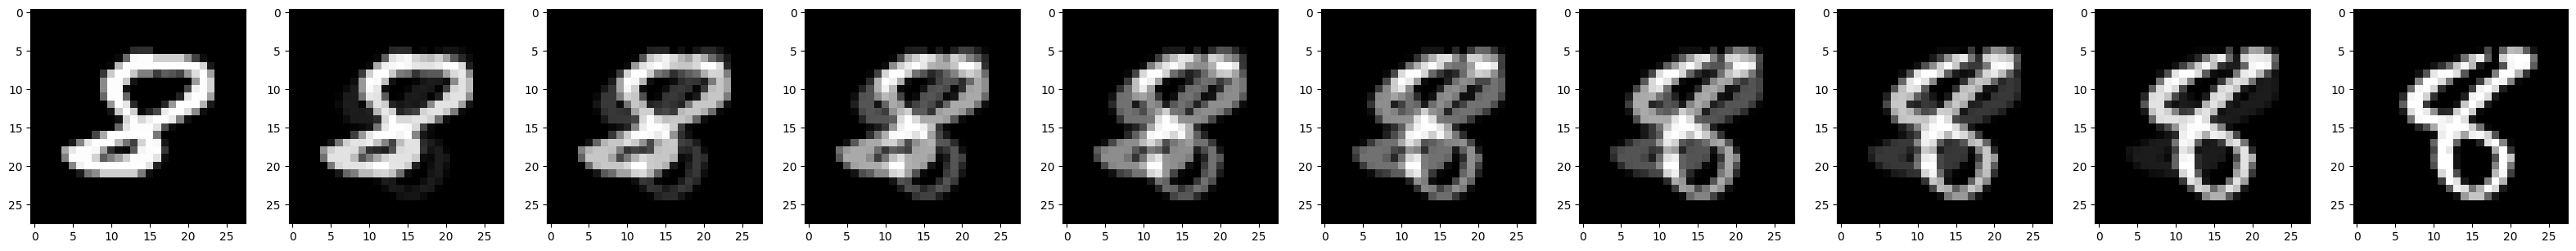

In [30]:
# Гомотопия между первыми двумя восьмерками

# 61 и 84 выбраны не случайно, под такими индексами в тестовых данных хранятся восьмерки

frm = dataset_test[61][0]
to = dataset_test[84][0]
plot_homotopy(frm, to)

Если наше латентное пространтсво корректное, мы нашли правильно параметаризованное латентное пространство, 
то небольшие сдвиги в этом пространстве должны давать разумные результаты: 

**Можно сказать то же самое, но завернуть это более витиевато:** Если же двигаться по кривой между кодами (и если многообразие кодов хорошо параметризовано), то декодер переведет эту кривую из пространства кодов, в кривую, не покидающую определяющее многообразие в пространстве объектов. То есть промежуточные объекты на кривой будут принадлежать генеральной совокупности.

In [31]:
conv_model.encoder(frm[None, :, :, :].to(DEVICE)).shape

torch.Size([1, 1, 7, 7])

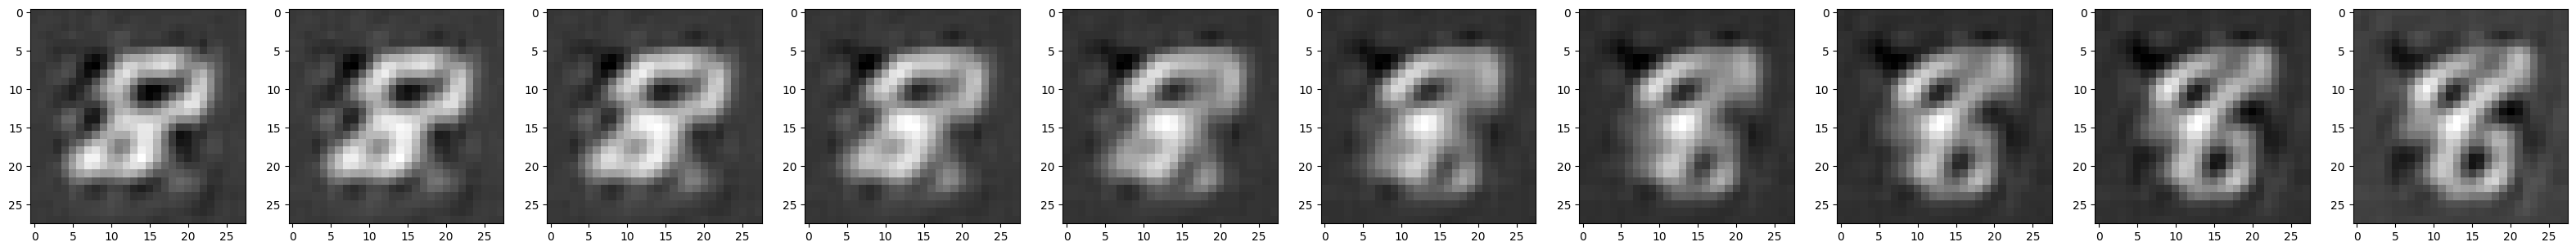

In [32]:
frm = dataset_test[61][0]
to = dataset_test[84][0]

with torch.no_grad():
    frm_enc = conv_model.encoder(frm[None, :, :, :].to(DEVICE))
    to_enc = conv_model.encoder(to[None, :, :, :].to(DEVICE))
    codes = torch.cat([frm_enc, to_enc])

plot_homotopy(codes[0], codes[1], n=10, decode=True)